In [11]:
import sys
import os
sys.path.append("/home/jshe/molecular_attention_bias/src")

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.biased_attention_transformer import BiasedAttentionTransformer

In [12]:
from attention_bias.utils.datasets import NPYDataset
from attention_bias.utils.point_clouds import collate_tokenize
from torch.utils.data import DataLoader

validation_dataset = NPYDataset(*[
    '/scratch/midway3/jshe/data/qm9/scaffolded/validation/atoms.npy',
    '/scratch/midway3/jshe/data/qm9/scaffolded/validation/coordinates.npy',
    '/scratch/midway3/jshe/data/qm9/scaffolded/validation/y.npy', 
])
dataloader = DataLoader(validation_dataset, collate_fn=collate_tokenize, batch_size=4096, shuffle=False)

## Training Curves

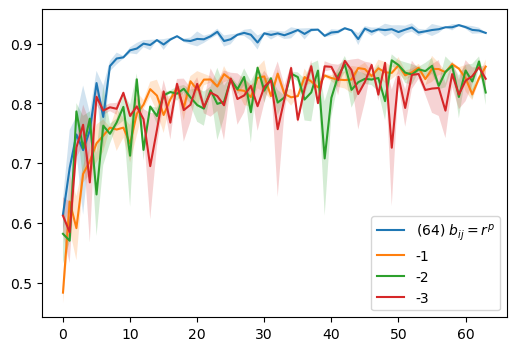

In [14]:
labels, log_dirs = zip(*[
    #('$a_{ij}=r^{-1}$', './weighted_graph/logs/FixedPowerLaw1/E128_H8_D8/'), 
    #('$a_{ij}=r^{-2}$', './weighted_graph/logs/FixedPowerLaw2/E128_H8_D8/'), 
    #('$a_{ij}=r^p$', './weighted_graph/logs/PowerLaw/E128_H8_D8/'), 
    #('(128) $b_{ij}=r^p$', './attention_bias/logs/PowerLaw/E128_H8_D8/'), 
    ('(64) $b_{ij}=r^p$', './attention_bias/logs/PowerLaw/E64_H8_D8/'), 
    ('-1', './attention_bias/logs/FixedPowerLaw-1/E64_H8_D8/'), 
   #('-1.5', './attention_bias/logs/FixedPowerLaw-1.5/E64_H8_D8/'), 
    ('-2', './attention_bias/logs/FixedPowerLaw-2/E64_H8_D8/'), 
    #('-2.25', './attention_bias/logs/FixedPowerLaw-2.25/E64_H8_D8/'), 
    #('-2.5', './attention_bias/logs/FixedPowerLaw-2.5/E64_H8_D8/'), 
    ('-3', './attention_bias/logs/FixedPowerLaw-3/E64_H8_D8/'), 
    #('(32) $b_{ij}=r^p$', './attention_bias/logs/PowerLaw/E32_H4_D4/'), 
    #('Masking', './mask/logs/E128_H8_D8/'), 
    #('RWPE', './positional_encoding/logs/RandomWalkPE_E128_H8_D8/'), 
])

fig, ax = plt.subplots(figsize=(6, 4))

for label, logdir in zip(labels, log_dirs):
    scores = []
    for logfile in os.listdir(logdir):
        if not logfile.endswith('.csv'): continue
        arr = pd.read_csv(logdir + logfile)['validation_r2'][:64]
        if len(arr) < 64: continue
        scores.append(arr)

        #ax.plot(arr, color='black', alpha=0.25)

    scores = np.stack(scores)
    mean = scores.mean(axis=0)
    std = scores.std(axis=0)
    ax.plot(mean, label=label)
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

ax.legend()

## Comparing fixed power laws

In [ ]:
exponents, log_dirs, pt_path = zip(*[
    (-1, './attention_bias/logs/FixedPowerLaw-1/E64_H8_D8/'), 
    (-1.5, './attention_bias/logs/FixedPowerLaw-1.5/E64_H8_D8/'), 
    (-2, './attention_bias/logs/FixedPowerLaw-2/E64_H8_D8/'), 
    (-2.25, './attention_bias/logs/FixedPowerLaw-2.25/E64_H8_D8/'), 
    (-2.5, './attention_bias/logs/FixedPowerLaw-2.5/E64_H8_D8/'), 
    (-3, './attention_bias/logs/FixedPowerLaw-3/E64_H8_D8/'), 
])

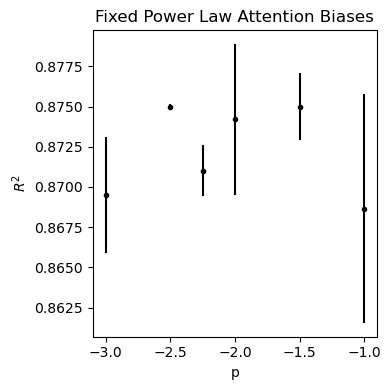

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))


x, y, y_err = [], [], []

for p, logdir in zip(exponents, log_dirs):

    scores = []
    for logfile in os.listdir(logdir):
        if not logfile.endswith('.csv'): continue
        arr = pd.read_csv(logdir + logfile)['validation_r2'][:64]
        if len(arr) < 64: print(logdir + logfile)
        scores.append(arr[np.argpartition(arr, -4)[-4:]].mean())

    x.append(p)
    y.append(np.mean(scores))
    y_err.append(np.std(scores))

ax.errorbar(x, y, yerr=y_err, fmt='k.')
ax.set_xlabel('p')
ax.set_ylabel('$R^2$')
ax.set_title('Fixed Power Law Attention Biases')

plt.tight_layout()

## Comparing validation set performance of Fixed Power Laws

In [13]:
exponents, model_paths = zip(*[
    (-1, './attention_bias/weights/FixedPowerLaw-1/E128_H8_D8/'), 
    (-1.5, './attention_bias/weights/FixedPowerLaw-1.5/E128_H8_D8/'), 
    (-2, './attention_bias/weights/FixedPowerLaw-2/E128_H8_D8/'), 
    (-2.5, './attention_bias/weights/FixedPowerLaw-2.5/E128_H8_D8/'), 
    (-3, './attention_bias/weights/FixedPowerLaw-3/E128_H8_D8/'), 
    (-3.5, './attention_bias/weights/FixedPowerLaw-3.5/E128_H8_D8/'), 
    (-4, './attention_bias/weights/FixedPowerLaw-4/E128_H8_D8/'), 
])

x, y, y_err = [], [], []
for exponent, model_path in zip(exponents, model_paths):

    losses = []

    print(f'Exponent: {exponent}')

    for file in os.listdir(model_path):
        if not file.endswith('.pt'): continue
        pt_path = os.path.join(model_path, file)
        
        model = Transformer(
            n_tokens=6, 
            out_features=15, 
            E=128, H=8, D=8, 
            BiasMap=bias_maps.FixedPowerLaw, 
            p=exponent 
        )
        model.load_state_dict(torch.load(pt_path, map_location='cpu'))
        model.eval()

        tokens, padding, coordinates, y_true = next(iter(dataloader))

        loss = torch.nn.functional.mse_loss(
            model(tokens, coordinates, padding), 
            y_true
        )
        losses.append(loss.item())

    x.append(exponent)
    y.append(np.mean(losses))
    y_err.append(np.std(losses))


Exponent: -1
Exponent: -1.5
Exponent: -2
Exponent: -2.5
Exponent: -3
Exponent: -3.5
Exponent: -4


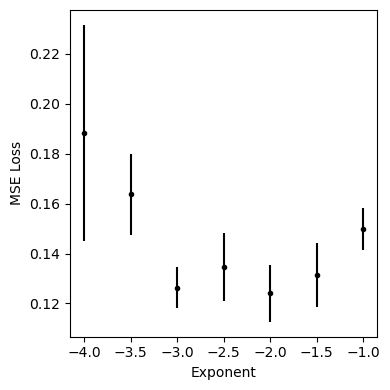

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.errorbar(x, y, yerr=y_err, fmt='k.')
ax.set_xlabel('Exponent')
ax.set_ylabel('MSE Loss')
plt.tight_layout()

## Distribution

In [5]:
labels, log_dirs = zip(*[
    ('(128) $b_{ij}=r^{-1}$', './attention_bias/logs/FixedPowerLaw_p_-1/E128_H8_D8/'), 
    ('(128) $b_{ij}=r^{-2}$', './attention_bias/logs/FixedPowerLaw_p_-2/E128_H8_D8/'), 
    ('$a_{ij}=r^{-1}$', './weighted_graph/logs/FixedPowerLaw1/E128_H8_D8/'), 
    ('$a_{ij}=r^{-2}$', './weighted_graph/logs/FixedPowerLaw2/E128_H8_D8/'), 
    ('(128) $a_{ij}=r^p$', './weighted_graph/logs/PowerLaw/E128_H8_D8/'), 
    ('(64) $a_{ij}=r^p$', './weighted_graph/logs/PowerLaw/E64_H4_D4/'), 
    ('(128) $b_{ij}=r^p$', './attention_bias/logs/PowerLaw/E128_H8_D8/'), 
    ('(64) $b_{ij}=r^p$', './attention_bias/logs/PowerLaw/E64_H4_D4/'), 
    ('(32) $b_{ij}=r^p$', './attention_bias/logs/PowerLaw/E32_H4_D4/'), 
    ('Gaussian Kernel', './attention_bias/logs/GaussianKernel/E128_H8_D8/'), 
    ('Masking', './mask/logs/E128_H8_D8/'), 
    ('RWPE', './positional_encoding/logs/RandomWalkPE_E128_H8_D8/'), 
])

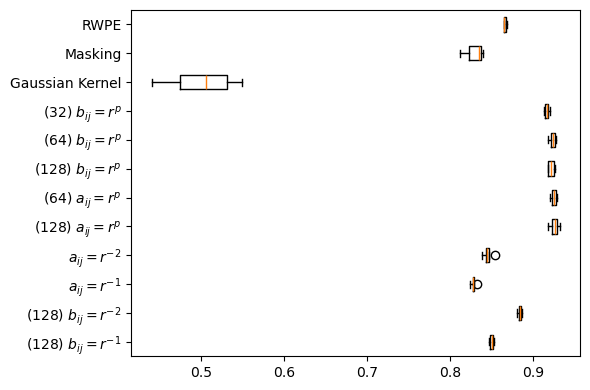

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

log_scores = []

for logdir in log_dirs:

    scores = []
    for logfile in os.listdir(logdir):
        if not logfile.endswith('.csv'): continue
        arr = pd.read_csv(logdir + logfile)['validation_r2'][:64]
        if len(arr) < 64: print(logdir + logfile)
        scores.append(arr[np.argpartition(arr, -4)[-4:]].mean())

    log_scores.append(scores)

ax.boxplot(
    log_scores, tick_labels=labels, 
    vert=False
)
plt.tight_layout()

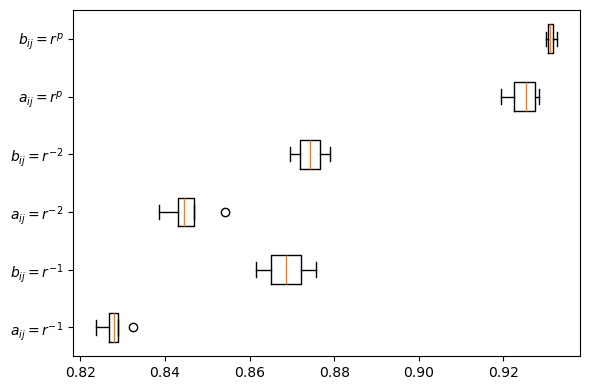

In [2]:
labels, log_dirs = zip(*[
    ('$a_{ij}=r^{-1}$', './weighted_graph/old_logs/FixedPowerLaw1/E128_H8_D8/'), 
    ('$b_{ij}=r^{-1}$', './attention_bias/old_logs/FixedPowerLaw-1/E64_H8_D8/'), 
    ('$a_{ij}=r^{-2}$', './weighted_graph/old_logs/FixedPowerLaw2/E128_H8_D8/'), 
    ('$b_{ij}=r^{-2}$', './attention_bias/old_logs/FixedPowerLaw-2/E64_H8_D8/'), 
    ('$a_{ij}=r^p$', './weighted_graph/old_logs/PowerLaw/E64_H4_D4/'), 
    ('$b_{ij}=r^p$', './attention_bias/old_logs/PowerLaw/E64_H8_D8/'), 
])

fig, ax = plt.subplots(figsize=(6, 4))

log_scores = []

for logdir in log_dirs:

    scores = []
    for logfile in os.listdir(logdir):
        if not logfile.endswith('.csv'): continue
        arr = pd.read_csv(logdir + logfile)['validation_r2'][:64]
        if len(arr) < 64: print(logdir + logfile)
        scores.append(arr[np.argpartition(arr, -4)[-4:]].mean())

    log_scores.append(scores)

ax.boxplot(
    log_scores, tick_labels=labels, 
    vert=False
)
plt.tight_layout()

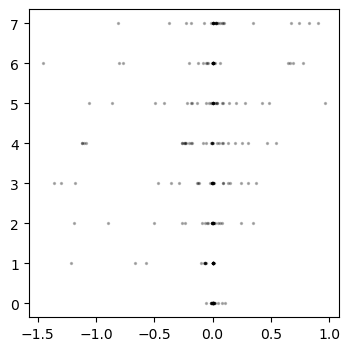

In [3]:
from weighted_graph.models.transformer import Transformer
from weighted_graph.models.weight_functions import *

weights_dir = "./weighted_graph/weights/PowerLaw/E128_H8_D8/"

layers = []
exponents = []
for weightsfile in os.listdir(weights_dir):
    if not weightsfile.endswith('.pt'): continue

    model = Transformer(
        n_tokens=6, 
        out_features=15, 
        E=128, H=8, D=8, 
        dropout=0.1, 
        WeightFunction=PowerLaw
    )
    model.load_state_dict(torch.load(weights_dir + weightsfile, map_location=torch.device('cpu')))

    for i, transformer_block in enumerate(model.transformer_blocks):
        layers += [i] * len(transformer_block.weight_function.p)
        exponents += list(transformer_block.weight_function.p.squeeze().detach())

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(exponents, layers, color='black', s=2, alpha=0.25)